In [1]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

16

In [2]:
import pandas as pd
import re

from nltk.stem import WordNetLemmatizer, SnowballStemmer                          
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem.porter import *

import numpy as np

import gensim


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression

/home/radu/miniconda3/envs/pytorch/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package wordnet to /home/radu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/radu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/radu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def preprocess_text(text, stemm=False, lemm=True, stop_words=None, model=None):
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    text = word_tokenize(text)
    if stopwords is not None:
        text = [word for word in text if not word in stop_words]
        text = [word.lower() for word in text if word.isalpha()]
                
    if stemm == True:
        ps = SnowballStemmer("english")
        text = [ps.stem(word) for word in text]
                
    if lemm == True:
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text]

    if model is not None:
        text = [model[word] for word in text if word in model]
    
    # text = np.asarray(text)
    # text = np.pad(text,[(0, 300-text.shape[0]), (0, 0)])
    # text = text.flatten('F')
    text = " ".join(text)
    return text

stop_words = set(stopwords.words('english'))

def process_DataFrame(df, model=None):
    texts = df['text'].apply(lambda t: preprocess_text(t, stemm=False, lemm=True, stop_words=stop_words, model=None))
    labels = df['label_x'].apply(lambda t: np.asarray(literal_eval(t.replace(" ", ","))))
    
    return texts, labels


In [4]:
from ast import literal_eval

training = pd.read_csv("../dataset/task2_merged_datsets/train_task2.csv", error_bad_lines=False)
validation = pd.read_csv("../dataset/task2_merged_datsets/val_task2.csv", error_bad_lines=False)

text_t, label_t = process_DataFrame(training)
text_v, label_v = process_DataFrame(validation)

In [5]:
vectorizer = TfidfVectorizer()

training_vocabulary = vectorizer.fit(text_t)

training_ = vectorizer.transform(text_t)

validation_ = vectorizer.transform(text_v)

In [6]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC

In [13]:
svm = LinearSVC(random_state=42)
# Make it an Multilabel classifier
multilabel_classifier = MultiOutputClassifier(svm, n_jobs=-1)

# Fit the data to the Multilabel classifier
multilabel_classifier = multilabel_classifier.fit(training_.todense(), label_t)
y_test_pred = multilabel_classifier.predict(validation_)

AttributeError: 'bool' object has no attribute 'any'

In [ ]:
import matplotlib.pyplot as plt

matrices = multilabel_confusion_matrix(y_test, y_test_pred)
cmd = ConfusionMatrixDisplay(matrices[0], display_labels=np.unique(y_test)).plot()
plt.title('Confusion Matrix for label 1')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[1], display_labels=np.unique(y_test)).plot()
plt.title('Confusion Matrix for label 2')
plt.show()

In [214]:
from sklearn.datasets import make_blobs

# Configuration options
num_samples_total = 10000
cluster_centers = [(5,5), (3,3)]
num_classes = len(cluster_centers)

# Generate data
X, classes = make_blobs(n_samples = num_samples_total, centers = cluster_centers, n_features = num_classes, center_box=(0, 1), cluster_std = 0.30)
colors = np.random.randint(0, 2, size=len(classes))

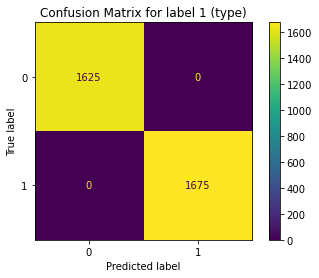

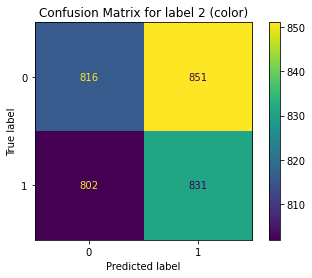

In [215]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay


# Get predictions for test data
y_test_pred = multilabel_classifier.predict(X_test)

# Generate multiclass confusion matrices
matrices = multilabel_confusion_matrix(y_test, y_test_pred)

# Plotting matrices: code
cmd = ConfusionMatrixDisplay(matrices[0], display_labels=np.unique(y_test)).plot()
plt.title('Confusion Matrix for label 1 (type)')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[1], display_labels=np.unique(y_test)).plot()
plt.title('Confusion Matrix for label 2 (color)')
plt.show()

In [218]:
y_train[0]

array([0, 1])

In [217]:
X_train

array([[5.56558495, 5.01793094],
       [4.63629144, 5.00808087],
       [5.18482122, 5.26186072],
       ...,
       [2.63251585, 2.87938143],
       [3.40488956, 3.15299636],
       [3.20224829, 2.90414901]])

In [12]:
print()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
